In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from customdataset import CustomImageDataset

num_classes : 10
classe_names : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


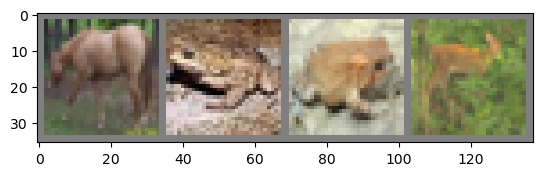

horse frog  frog  deer 
Device:  cpu
[1,  2000] loss: 2.240
[1,  4000] loss: 1.946
[2,  2000] loss: 1.631
[2,  4000] loss: 1.545
[3,  2000] loss: 1.411
[3,  4000] loss: 1.381
[4,  2000] loss: 1.275
[4,  4000] loss: 1.257
[5,  2000] loss: 1.149
[5,  4000] loss: 1.166
Finished Training


In [5]:
batch_size = 4

transform = transforms.Compose( 
    [transforms.ToTensor(), ## 0~~255를 0~1로 바꿔줌 
        transforms.Resize(32),  ## 이미지 사이즈 조절 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 
        ## 데이터 분포 표준화 0.5는 RGB (R:0.5, G;0.5, B:0.5) 

data_path = "./dataset"
train_data_set = CustomImageDataset(data_set_path=f"{data_path}/train",
                                    transforms=transform)
trainloader = torch.utils.data.DataLoader(train_data_set, batch_size=batch_size, shuffle=True)

test_data_set = CustomImageDataset(data_set_path=f"{data_path}/test",
                                    transforms=transform)
testloader = torch.utils.data.DataLoader(test_data_set, batch_size=batch_size, shuffle=False)

num_classes = train_data_set.num_classes
classes = train_data_set.class_names

print("num_classes :", num_classes)
print("classe_names :", classes)


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2) ## 이미지 사이즈 줄이는 함수 
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        ## 컨벌루션 한 번(입력과 출력) -> 이미지 축소 -> 컨벌루션 한 번(입력과 출력)  
        
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

net = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

n_epochs = 5

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        ## 항상 요순서대로 

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

# Let's quickly save our trained model:

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

del dataiter